# Prelude

In [1]:
import itertools
import json
import re
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy.stats import spearmanr

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

sns.set_theme(
    context='notebook',
    style='whitegrid',
    rc={
        'axes.unicode_minus': False,
        'text.usetex': True,
        'font.family': ['sans-serif'],
        'font.sans-serif': ['CMU Sans Serif'],
        'text.latex.preamble': '\\usepackage{sfmath}\\usepackage{amssymb}'
    }
)

Path('figures').mkdir(exist_ok=True)

Static benchmarks in each language:

In [2]:
BASQUE_TASKS = [
    'arc_eu_challenge',
    'arc_eu_easy',
    'basqbbq',
    'belebele_eus_Latn',
    'bertaqa_eu_local',
    'bertaqa_eu_global',
    'bl2mp',
    'eus_exams_eu',
    'eus_proficiency',
    'eus_reading',
    'eus_trivia',
    'mgsm_native_cot_eu',
    'mmlu_eu',
    'piqa_eu',
    'xstorycloze_eu'
]

ENGLISH_TASKS = [
    'arc_challenge',
    'arc_easy',
    'bbq',
    'belebele_eng_Latn',
    'bertaqa_en_global',
    'bertaqa_en_local',
    'mgsm_native_cot_en',
    'mmlu_en',
    'piqa',
    'xstorycloze_en'
]

SPANISH_TASKS = [
    'belebele_spa_Latn',
    'mgsm_native_cot_es',
    'mmlu_es',
    'xstorycloze_es'
]

Handy variables to handle models names:

In [3]:
MODELS = [
    # proprietary
    'claude-3-5-sonnet-20241022',
    'gpt-4o-2024-11-20',
    # 70B
    'Llama-3.1-70B-Instruct',
    'Latxa-Llama-3.1-70B-Instruct',
    # 8B BASE_EN (exp_0)
    'Llama-3.1-8B', 'exp_0_010', 'exp_0_011', 'exp_0_101', 'exp_0_110', 'exp_0_111',
    # 8B BASE_EU (exp_1)
    'Latxa-Llama-3.1-8B', 'exp_1_001', 'exp_1_010', 'exp_1_011', 'exp_1_101', 'exp_1_110', 'exp_1_111',
    # 8B INST_EN (exp_2)
    'Llama-3.1-8B-Instruct', 'exp_2_010', 'exp_2_011', 'exp_2_100', 'exp_2_101', 'exp_2_110', 'exp_2_111'
]

EXP_2_BASE_MODEL = {
    0: 'B{\\footnotesize ASE}\\textsubscript{\\,EN}',
    1: 'B{\\footnotesize ASE}\\textsubscript{\\,EU}',
    2: 'I{\\footnotesize NSTRUCT}\\textsubscript{\\,EN}'
}

MODEL_ALIASES = {
    'Llama-3.1-8B': '0_000',
    'Latxa-Llama-3.1-8B': '1_000',
    'Llama-3.1-8B-Instruct': '2_000',
    'claude-3-5-sonnet-20241022': 'Claude 3.5 Sonnet',
    'gpt-4o-2024-11-20': 'GPT-4o', 'gpt-4o': 'GPT-4o',
    'Latxa-Llama-3.1-70B-Instruct': 'INS\\textsubscript{\\,EN,70B}\\,C\\textsubscript{\\,EU}\\,I\\textsubscript{\\,EN}',
    'Latxa 3.1 70B Instruct': 'INS\\textsubscript{\\,EN,70B}\\,C\\textsubscript{\\,EU}\\,I\\textsubscript{\\,EN}'
}
MODEL_EQUIVALENCES = {'2_000': ['0_001', '2_001'], '1_000': ['0_100', '1_100']}

BASE_MODEL = 0
BASQUE_PRETRAINING_CORPUS = 1
BASQUE_INSTRUCTION_CORPUS = 2
ENGLISH_INSTRUCTION_CORPUS = 3

In [4]:
def normalize_model_name(m: str) -> str:
    m = MODEL_ALIASES.get(m, m)
    m = m.replace('exp_', '')
    return m

def pretty_model_name(m: str) -> str:
    backbone, corpus, *inst = model_name_parts(m, as_int=True)
    if corpus == -1:
        return backbone
    pretty_backbone = {0: 'BAS\\textsubscript{\\,EN}', 1: 'BAS\\textsubscript{\\,EU}', 2: 'INS\\textsubscript{\\,EN}'}
    pretty_corpus = {0: '', 1: '\\,C\\textsubscript{\\,EU}'}
    pretty_inst = {(0,0): '', (0,1): '\\,I\\textsubscript{\\,EN}', (1,0): '\\,I\\textsubscript{\\,EU}', (1,1): '\\,I\\textsubscript{\\,EN+EU}'}
    return f'{pretty_backbone[backbone]}{pretty_corpus[corpus]}{pretty_inst[tuple(inst)]}'

def expand_equivalences(df, key: str = 'model'):
    for src, tgts in MODEL_EQUIVALENCES.items():
        src_df = df[df[key] == src]
        for tgt in tgts:
            tgt_df = src_df.copy()
            tgt_df[key] = tgt
            df = pd.concat([df, tgt_df], ignore_index=True)
    return df

def model_name_parts(model_name: str, as_int: bool = False) -> tuple:
    match = re.match(r'^(\d)_(\d)(\d)(\d)$', model_name)
    if match is None:
        return model_name, -1, -1, -1
    parts = int(match.group(1)), int(match.group(2)), int(match.group(3)), int(match.group(4))
    if as_int:
        return parts
    return EXP_2_BASE_MODEL[parts[0]], bool(parts[1]), bool(parts[2]), bool(parts[3])

def mask_model_name(by: list[int], model_name: str) -> tuple[str, str]:
    variant = ''
    parts = list(model_name_parts(model_name, as_int=True))
    if parts[-1] == -1:
        return model_name, variant
    for pos in by:
        variant += str(int(parts[pos]))
        parts[pos] = 'X'
    return f'{parts[0]}_{parts[1]}{parts[2]}{parts[3]}', variant

# Full benchmark results

In [5]:
def load_benchmark_results(apply_equivalences: bool = True) -> pd.DataFrame:
    records = []
    for file_path in Path('benchmarks/results').rglob('*.json'):
        model_name = file_path.parent.name.split('__')[-1]
        if model_name not in MODELS:
            continue
        with file_path.open('r') as f:
            content = json.load(f)
            for task, metrics in content.get('results', {}).items():
                if 'mgsm' in task:
                    score = metrics.get('exact_match,flexible-extract')
                    stderr = metrics.get('exact_match_stderr,flexible-extract')
                elif 'gpt' in model_name or 'claude' in model_name:
                    score = metrics.get('exact_match,strict_match')
                    stderr = metrics.get('exact_match_stderr,strict_match')
                else:
                    score = metrics.get('acc,none')
                    stderr = metrics.get('acc_stderr,none')
                if score is not None:
                    n = sum(v['effective'] for k, v in content['n-samples'].items())
                    records.append({'model': model_name, 'task': task, 'score': score, 'stderr': stderr, 'n': n})
    df = pd.DataFrame(records)
    df['model'] = df['model'].apply(normalize_model_name).replace(MODEL_ALIASES)
    if apply_equivalences:
        df = expand_equivalences(df, key='model')
    return df

def process_benchmark_results(df: pd.DataFrame, tasks_filter: list = None, values: str = 'score') -> pd.DataFrame:
    if tasks_filter is not None:
        df = df[df['task'].isin(tasks_filter)]
    df = df.pivot_table(index=['model'], columns='task', values=values).reset_index()
    df = df.set_index('model')
    return df.T

def benchmarks_to_pretty_table(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy() * 100
    mean = df.mean()
    df.loc['mean'] = mean
    df = df.round(2)
    df.loc['rank'] = mean.rank(method='max', ascending=False)
    df = df[sorted(df.columns)]
    df.columns = [pretty_model_name(m) for m in df.columns]
    return df.T

In [6]:
benchmark_with_equiv_df = load_benchmark_results(apply_equivalences=True)

In [7]:
benchmarks_eu_with_equiv_df = process_benchmark_results(benchmark_with_equiv_df, tasks_filter=BASQUE_TASKS)
benchmarks_eu_with_equiv_df = benchmarks_eu_with_equiv_df.drop(index=['basqbbq'])

pretty_eu_df = benchmarks_to_pretty_table(benchmarks_eu_with_equiv_df)
display(pretty_eu_df)

pretty_eu_df.drop(columns=['rank']).to_latex('figures/benchmark-full-eu.tex', sparsify=False, float_format='{:.2f}'.format)

task,arc_eu_challenge,arc_eu_easy,belebele_eus_Latn,bertaqa_eu_global,bertaqa_eu_local,bl2mp,eus_exams_eu,eus_proficiency,eus_reading,eus_trivia,mgsm_native_cot_eu,mmlu_eu,piqa_eu,xstorycloze_eu,mean,rank
"BAS\textsubscript{\,EN}",28.84,49.75,61.56,63.29,43.65,74.06,45.63,32.69,47.44,43.79,26.4,47.41,56.92,56.72,48.44,28.0
"BAS\textsubscript{\,EN}\,I\textsubscript{\,EN}",29.10,50.88,73.89,67.10,44.97,69.61,46.21,34.13,49.72,45.01,45.6,50.37,57.63,61.22,51.82,27.0
"BAS\textsubscript{\,EN}\,I\textsubscript{\,EU}",36.35,61.95,69.44,67.39,42.98,84.06,48.39,35.42,44.89,45.42,30.8,50.37,61.44,62.14,52.93,24.0
"BAS\textsubscript{\,EN}\,I\textsubscript{\,EN+EU}",38.57,63.47,72.00,68.77,42.60,84.33,48.42,36.24,45.17,46.30,37.2,52.22,62.09,62.87,54.30,23.0
"BAS\textsubscript{\,EN}\,C\textsubscript{\,EU}",38.65,67.38,75.22,72.45,65.65,92.50,55.03,53.57,58.24,60.52,36.0,51.11,65.09,68.50,61.42,11.0
"BAS\textsubscript{\,EN}\,C\textsubscript{\,EU}\,I\textsubscript{\,EN}",39.42,64.81,73.00,70.99,63.49,91.28,51.92,48.66,56.82,56.33,47.2,51.85,67.32,69.36,60.89,14.0
"BAS\textsubscript{\,EN}\,C\textsubscript{\,EU}\,I\textsubscript{\,EU}",38.14,67.00,71.78,71.24,62.65,92.39,49.88,47.20,46.02,57.78,39.2,50.00,65.63,66.71,58.97,20.0
"BAS\textsubscript{\,EN}\,C\textsubscript{\,EU}\,I\textsubscript{\,EN+EU}",40.10,68.60,74.89,72.74,63.79,92.50,52.78,47.65,53.12,59.59,48.4,51.48,64.87,66.84,61.24,12.0
"BAS\textsubscript{\,EU}",38.65,67.38,75.22,72.45,65.65,92.50,55.03,53.57,58.24,60.52,36.0,51.11,65.09,68.50,61.42,11.0
"BAS\textsubscript{\,EU}\,I\textsubscript{\,EN}",40.36,63.93,72.22,70.94,63.20,90.11,52.21,48.31,59.09,57.78,45.6,52.22,65.85,70.55,60.88,15.0


In [8]:
benchmarks_en_with_equiv_df = process_benchmark_results(benchmark_with_equiv_df, tasks_filter=ENGLISH_TASKS)
benchmarks_en_with_equiv_df = benchmarks_en_with_equiv_df.drop(index=['bbq'])

pretty_en_df = benchmarks_to_pretty_table(benchmarks_en_with_equiv_df)
display(pretty_en_df)

pretty_en_df.drop(columns=['rank']).to_latex('figures/benchmark-full-en.tex', sparsify=False, float_format='{:.2f}'.format)

task,arc_challenge,arc_easy,belebele_eng_Latn,bertaqa_en_global,bertaqa_en_local,mgsm_native_cot_en,mmlu_en,piqa,xstorycloze_en,mean,rank
"BAS\textsubscript{\,EN}",54.61,84.30,87.78,75.59,49.11,55.2,67.78,80.79,81.34,70.72,25.0
"BAS\textsubscript{\,EN}\,I\textsubscript{\,EN}",57.76,85.48,92.67,77.47,50.51,87.2,66.67,81.28,83.52,75.84,7.0
"BAS\textsubscript{\,EN}\,I\textsubscript{\,EU}",54.95,83.63,86.78,73.95,47.38,67.6,63.70,80.63,82.46,71.23,21.0
"BAS\textsubscript{\,EN}\,I\textsubscript{\,EN+EU}",54.69,81.52,87.67,74.46,48.01,78.0,61.11,80.36,82.33,72.02,19.0
"BAS\textsubscript{\,EN}\,C\textsubscript{\,EU}",52.39,82.83,84.33,76.05,61.72,55.2,63.70,80.30,80.08,70.73,24.0
"BAS\textsubscript{\,EN}\,C\textsubscript{\,EU}\,I\textsubscript{\,EN}",53.84,80.72,85.89,75.75,60.41,79.2,60.00,79.71,82.40,73.10,12.0
"BAS\textsubscript{\,EN}\,C\textsubscript{\,EU}\,I\textsubscript{\,EU}",54.44,82.20,80.33,75.08,59.56,62.0,55.19,80.69,80.21,69.97,28.0
"BAS\textsubscript{\,EN}\,C\textsubscript{\,EU}\,I\textsubscript{\,EN+EU}",53.92,81.65,85.78,75.63,60.79,74.4,63.33,80.85,82.06,73.16,11.0
"BAS\textsubscript{\,EU}",52.39,82.83,84.33,76.05,61.72,55.2,63.70,80.30,80.08,70.73,24.0
"BAS\textsubscript{\,EU}\,I\textsubscript{\,EN}",53.33,80.68,86.44,74.50,59.22,73.6,61.11,80.09,81.54,72.28,17.0


In [9]:
benchmarks_es_with_equiv_df = process_benchmark_results(benchmark_with_equiv_df, tasks_filter=SPANISH_TASKS)

pretty_es_df = benchmarks_to_pretty_table(benchmarks_es_with_equiv_df)
display(pretty_es_df)

pretty_es_df.drop(columns=['rank']).to_latex('figures/benchmark-full-es.tex', sparsify=False, float_format='{:.2f}'.format)

task,belebele_spa_Latn,mgsm_native_cot_es,mmlu_es,xstorycloze_es,mean,rank
"BAS\textsubscript{\,EN}",81.67,50.4,57.41,74.06,65.88,22.0
"BAS\textsubscript{\,EN}\,I\textsubscript{\,EN}",87.89,78.8,62.96,77.50,76.79,7.0
"BAS\textsubscript{\,EN}\,I\textsubscript{\,EU}",80.67,58.4,57.78,74.12,67.74,19.0
"BAS\textsubscript{\,EN}\,I\textsubscript{\,EN+EU}",82.00,67.6,58.89,75.31,70.95,13.0
"BAS\textsubscript{\,EN}\,C\textsubscript{\,EU}",79.11,46.8,58.52,72.20,64.16,27.0
"BAS\textsubscript{\,EN}\,C\textsubscript{\,EU}\,I\textsubscript{\,EN}",81.33,63.6,60.00,73.53,69.62,14.0
"BAS\textsubscript{\,EN}\,C\textsubscript{\,EU}\,I\textsubscript{\,EU}",75.22,58.0,53.70,72.01,64.73,24.0
"BAS\textsubscript{\,EN}\,C\textsubscript{\,EU}\,I\textsubscript{\,EN+EU}",80.33,62.8,61.11,73.40,69.41,15.0
"BAS\textsubscript{\,EU}",79.11,46.8,58.52,72.20,64.16,27.0
"BAS\textsubscript{\,EU}\,I\textsubscript{\,EN}",78.11,64.4,58.15,72.73,68.35,18.0


# Full arena results

In [10]:
from datasets import load_dataset
from evaluation.human.frontend.scoring import get_leaderboard_df

def load_arena_results(apply_equivalences: bool = False) -> pd.DataFrame:
    data = load_dataset('HiTZ/ebaluatoia', name='25-03')
    df = pd.DataFrame(data['train']).sort_values(ascending=True, by=['timestamp'])
    df['model_a'] = df['model_a'].apply(normalize_model_name).replace(MODEL_ALIASES)
    df['model_b'] = df['model_b'].apply(normalize_model_name).replace(MODEL_ALIASES)
    if apply_equivalences:
        df = expand_match_equivalences(df)
    return df

def process_arena_results(df: pd.DataFrame, apply_equivalences: bool = False) -> pd.DataFrame:
    def str2int(text: str | float, rx: str):
        if isinstance(text, float):
            return 0  # nan
        return int(re.search(rx, text).group(1))
    df = get_leaderboard_df(df)
    df = df.rename(columns={'Model': 'model'})
    if apply_equivalences:
        df = expand_equivalences(df, key='model')
    df['ELO upper'] = df.apply(lambda x: str2int(x['90% CI'], r'\+(\d+)'), axis=1)
    df['ELO lower'] = df.apply(lambda x: str2int(x['90% CI'], r'-(\d+)'), axis=1)
    return df

def arena_to_pretty_table(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['rank'] = df['ELO'].rank(method='max', ascending=False)
    df = df[['model', 'rank', 'ELO', '90% CI']]
    df['model'] = df['model'].apply(pretty_model_name)
    df =  df.set_index('model')
    df = df.round(2)
    return df

def expand_match_equivalences(df: pd.DataFrame) -> pd.DataFrame:
    records = []
    for _, row in df.iterrows():
        a_expansions = [row['model_a']] + MODEL_EQUIVALENCES.get(row['model_a'], [])
        b_expansions = [row['model_b']] + MODEL_EQUIVALENCES.get(row['model_b'], [])
        for a in a_expansions:
            for b in b_expansions:
                record = row.copy()
                record['model_a'] = a
                record['model_b'] = b
                records.append(record)
    return pd.DataFrame(records)

def mirror_matches(df: pd.DataFrame) -> pd.DataFrame:
    mirror_df = df.copy()
    mirror_df = mirror_df.rename(columns={'model_a': 'model_b', 'model_b': 'model_a'})
    mirror_df['winner'] = mirror_df['winner'].replace({'model_a': 'model_b', 'model_b': 'model_a'})
    mirror_df['winner_content'] = mirror_df['winner_content'].replace({'model_a': 'model_b', 'model_b': 'model_a'})
    mirror_df['winner_language'] = mirror_df['winner_language'].replace({'model_a': 'model_b', 'model_b': 'model_a'})
    return pd.concat([df, mirror_df])

/home/nperez/.venv/instruct-utils/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
arena_df = load_arena_results(apply_equivalences=False)

### Participant analysis

In [12]:
arena_participation_df = arena_df[['timestamp', 'username', 'user_language', 'user_education']]

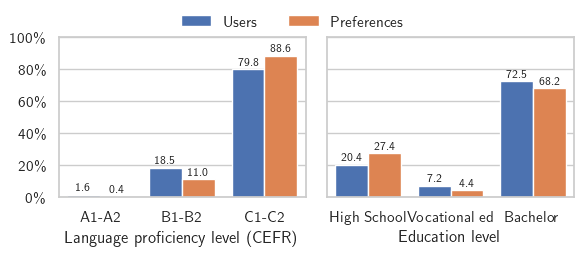

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2.5), sharey=True)

unique_users_lang = arena_participation_df.groupby('user_language')['username'].nunique().reset_index()
unique_users_lang.columns = ['user_language', 'count']
unique_users_lang['percentage'] = (unique_users_lang['count'] / unique_users_lang['count'].sum()) * 100
unique_users_lang['type'] = 'Users'

total_submissions_lang = arena_participation_df['user_language'].value_counts().reset_index()
total_submissions_lang.columns = ['user_language', 'count']
total_submissions_lang['percentage'] = (total_submissions_lang['count'] / total_submissions_lang['count'].sum()) * 100
total_submissions_lang['type'] = 'Preferences'

hizk_data = pd.concat([
    unique_users_lang[['user_language', 'percentage', 'type']],
    total_submissions_lang[['user_language', 'percentage', 'type']]
])

sns.barplot(data=hizk_data, x='user_language', y='percentage', hue='type', ax=ax1, saturation=1)

ax1.set_xlabel('Language proficiency level (CEFR)')
ax1.set_ylabel(None)
ax1.set_ylim(0, 100)
ax1.yaxis.set_major_formatter(PercentFormatter())
ax1.get_legend().remove()

for p in ax1.patches:
    p_height = p.get_height()
    if p_height > 0:
        ax1.annotate(
            f"{p_height :.1f}%",
            (p.get_x() + p.get_width() / 2., p_height),
            ha='center', va='center',
            xytext=(0, 5),
            textcoords='offset points',
            fontsize=8
        )

unique_users_edu = arena_participation_df.groupby('user_education')['username'].nunique().reset_index()
unique_users_edu.columns = ['user_education', 'count']
unique_users_edu['percentage'] = (unique_users_edu['count'] / unique_users_edu['count'].sum()) * 100
unique_users_edu['type'] = 'Users'

total_submissions_edu = arena_participation_df['user_education'].value_counts().reset_index()
total_submissions_edu.columns = ['user_education', 'count']
total_submissions_edu['percentage'] = (total_submissions_edu['count'] / total_submissions_edu['count'].sum()) * 100
total_submissions_edu['type'] = 'Preferences'

hezk_data = pd.concat([
    unique_users_edu[['user_education', 'percentage', 'type']],
    total_submissions_edu[['user_education', 'percentage', 'type']]
])

sns.barplot(data=hezk_data, x='user_education', y='percentage', hue='type', order=['High School', 'Vocational ed', 'Bachelor'], ax=ax2, saturation=1)

ax2.set_xlabel('Education level')
ax2.set_ylabel(None)
ax2.set_ylim(0, 100)
ax2.get_legend().remove()

for p in ax2.patches:
    p_height = p.get_height()
    if p_height > 0:
        ax2.annotate(
            f"{p_height:.1f}%",
            (p.get_x() + p.get_width() / 2., p_height),
            ha='center', va='center',
            xytext=(0, 5),
            textcoords='offset points',
            fontsize=8
        )


handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False)

plt.tight_layout()
plt.savefig('figures/arena-participants.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Bradley--Terry scores and rankings

In [14]:
elo_df = process_arena_results(arena_df, apply_equivalences=False)
pretty_elo_df = arena_to_pretty_table(elo_df)

lang_arena_df = arena_df.copy().drop(columns=['winner']).rename(columns={'winner_language': 'winner'})
lang_elo_df = process_arena_results(lang_arena_df, apply_equivalences=False)
pretty_lang_elo_df = arena_to_pretty_table(lang_elo_df)

cont_arena_df = arena_df.copy().drop(columns=['winner']).rename(columns={'winner_content': 'winner'})
cont_elo_df = process_arena_results(cont_arena_df, apply_equivalences=False)
pretty_cont_elo_df = arena_to_pretty_table(cont_elo_df)

In [15]:
full_elo_df = pretty_elo_df \
    .merge(pretty_cont_elo_df, on='model', how='left', suffixes=['', '_cont']) \
    .merge(pretty_lang_elo_df, on='model', how='left', suffixes=['', '_lang'])

full_elo_df['rank_cont_delta'] = full_elo_df['rank_cont'] - full_elo_df['rank']
full_elo_df['rank_lang_delta'] = full_elo_df['rank_lang'] - full_elo_df['rank']
full_elo_df = full_elo_df[[
    'rank', 'ELO', '90% CI',
    'rank_cont', 'rank_cont_delta', 'ELO_cont', '90% CI_cont',
    'rank_lang', 'rank_lang_delta', 'ELO_lang', '90% CI_lang'
]]

display(full_elo_df)

full_elo_df.to_latex('figures/arena-full.tex', sparsify=False, float_format='{:.2f}'.format, formatters={'rank': int})

,rank,ELO,90% CI,rank_cont,rank_cont_delta,ELO_cont,90% CI_cont,rank_lang,rank_lang_delta,ELO_lang,90% CI_lang
model,,,,,,,,,,,
GPT-4o,1.0,1188,+13/-17,1.0,0.0,1183,+15/-13,1.0,0.0,1093,+12/-10
Claude 3.5 Sonnet,2.0,1153,+13/-21,2.0,0.0,1150,+12/-17,3.0,1.0,1082,+11/-11
"INS\textsubscript{\,EN,70B}\,C\textsubscript{\,EU}\,I\textsubscript{\,EN}",3.0,1141,+15/-11,3.0,0.0,1127,+10/-11,2.0,-1.0,1083,+13/-13
"INS\textsubscript{\,EN}\,C\textsubscript{\,EU}\,I\textsubscript{\,EN+EU}",5.0,1050,+13/-14,4.0,-1.0,1047,+12/-12,4.0,-1.0,1038,+10/-8
"INS\textsubscript{\,EN}\,C\textsubscript{\,EU}\,I\textsubscript{\,EU}",5.0,1050,+14/-11,5.0,0.0,1045,+11/-13,6.0,1.0,1034,+8/-10
"INS\textsubscript{\,EN}\,C\textsubscript{\,EU}\,I\textsubscript{\,EN}",6.0,1038,+13/-13,6.0,0.0,1031,+15/-12,5.0,-1.0,1036,+11/-10
"BAS\textsubscript{\,EN}\,C\textsubscript{\,EU}\,I\textsubscript{\,EN+EU}",7.0,1025,+13/-11,7.0,0.0,1026,+13/-13,10.0,3.0,1019,+7/-12
"BAS\textsubscript{\,EU}\,C\textsubscript{\,EU}\,I\textsubscript{\,EN+EU}",8.0,1022,+13/-8,8.0,0.0,1019,+12/-11,9.0,1.0,1021,+10/-10
"BAS\textsubscript{\,EN}\,C\textsubscript{\,EU}\,I\textsubscript{\,EN}",9.0,1017,+12/-11,10.0,1.0,1004,+11/-14,7.0,-2.0,1027,+10/-9


### Battle counts & win rates

In [16]:
mirror_arena_df = mirror_matches(arena_df.copy().drop(columns=['timestamp', 'username', 'user_language', 'user_education', 'conv_a', 'conv_b']))

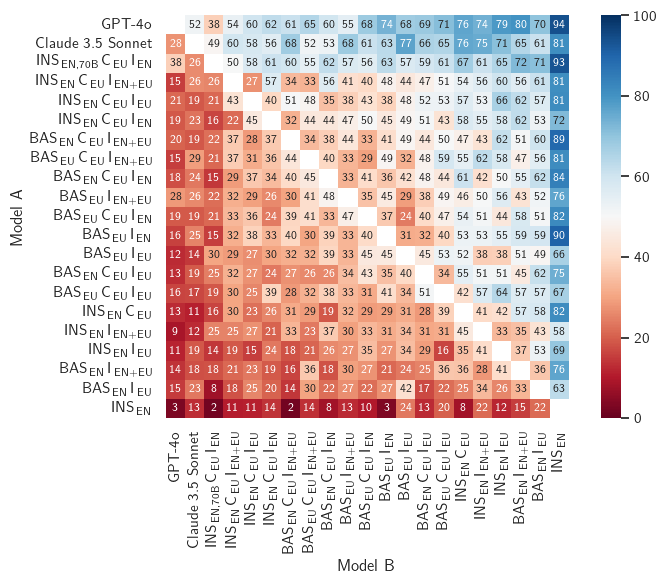

In [17]:
plt.figure(figsize=(8, 6))

plot_mirror_arena_df = mirror_arena_df.copy()

plot_mirror_arena_df['model_a'] = plot_mirror_arena_df['model_a'].apply(pretty_model_name)
plot_mirror_arena_df['model_b'] = plot_mirror_arena_df['model_b'].apply(pretty_model_name)

win_counts_df = plot_mirror_arena_df.groupby(['model_a', 'model_b', 'winner']).size().unstack(fill_value=0)

win_rates_df = pd.DataFrame(index=win_counts_df.index.levels[0], columns=win_counts_df.index.levels[1])
for (model_a, model_b), row in win_counts_df.iterrows():
    total = row.sum()
    a_wins = row.get('model_a', 0)
    tie = row.get('tie', 0)
    b_wins = row.get('model_b', 0)
    win_rate = 100 * a_wins / (a_wins + tie + b_wins)
    win_rates_df.loc[model_a, model_b] = win_rate
win_rates_df = win_rates_df.astype(float)
pretty_index = elo_df['model'].apply(pretty_model_name)
win_rates_df = win_rates_df.reindex(pretty_index, axis=0).reindex(pretty_index, axis=1)

sns.heatmap(win_rates_df, square=True, annot=True, fmt='.0f', cmap='RdBu', vmin=0, vmax=100, center=50, annot_kws={'size': 8})
plt.ylabel('Model A')
plt.xlabel('Model B')
plt.grid(visible=False)

plt.tight_layout()
plt.savefig('figures/arena-win_rates-heatmap.pdf', dpi=300)
plt.show()

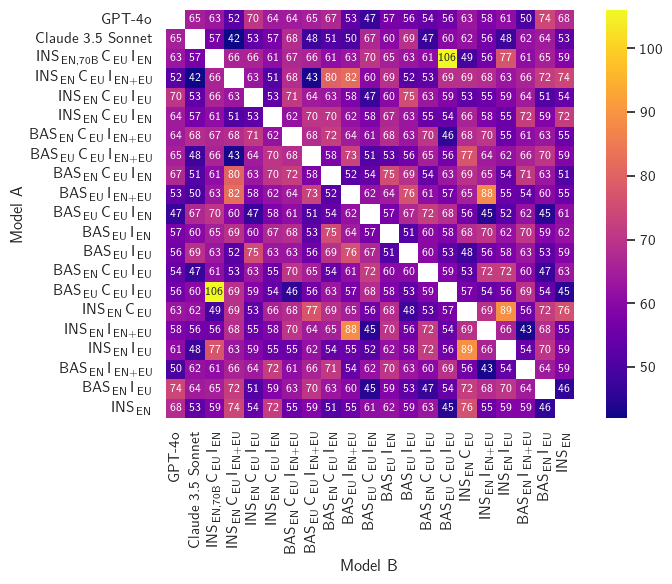

In [18]:
plt.figure(figsize=(8, 6))

battle_counts_df = plot_mirror_arena_df.groupby(['model_a', 'model_b']).size().unstack(fill_value=np.nan)
battle_counts_df = battle_counts_df.reindex(pretty_index, axis=0).reindex(pretty_index, axis=1)

sns.heatmap(battle_counts_df, square=True, annot=True, fmt='.0f', cmap='plasma', annot_kws={'size': 8})
plt.ylabel('Model A')
plt.xlabel('Model B')
plt.grid(visible=False)

plt.tight_layout()
plt.savefig('figures/arena-battle_counts-heatmap.pdf', dpi=300)
plt.show()

# Research questions

In [19]:
def grouped_results(df, by: list[int]) -> pd.DataFrame:

    records = {}
    model_variants = []
    for model, cols in df.iterrows():

        masked_model, model_variant = mask_model_name(by, model)
        model_variants.append(model_variant)
        if masked_model not in records:
            records[masked_model] = {}
        records[masked_model][('ELO', model_variant)] = cols['ELO']
        records[masked_model][('90% CI', model_variant)] = cols['90% CI']
        records[masked_model][('ELO upper', model_variant)] = cols['ELO upper']
        records[masked_model][('ELO lower', model_variant)] = cols['ELO lower']
        records[masked_model][('acc', model_variant)] = cols['acc']
    model_variants = sorted(set(model_variants), reverse=True)

    # compute aggregated ELO
    arena_tmp = arena_df.copy()
    arena_tmp = arena_tmp[arena_tmp['model_a'].isin(df.index) & arena_tmp['model_b'].isin(df.index)]
    arena_tmp['model_a'] = arena_tmp.apply(lambda x: mask_model_name(by, x['model_a'])[1], axis=1)
    arena_tmp['model_b'] = arena_tmp.apply(lambda x: mask_model_name(by, x['model_b'])[1], axis=1)
    grouped_elo = process_arena_results(arena_tmp, apply_equivalences=False).set_index(['model'])

    # "global" row
    records['global'] = {}
    for v in model_variants:
        if 'global' not in records:
            records['global'] = {}
        records['global'][('ELO', v)] = grouped_elo.loc[v]['ELO']
        records['global'][('90% CI', v)] = grouped_elo.loc[v]['90% CI']
        records['global'][('ELO upper', v)] = grouped_elo.loc[v]['ELO upper']
        records['global'][('ELO lower', v)] = grouped_elo.loc[v]['ELO lower']
        records['global'][('acc', v)] = np.nan  # later

    group_df = pd.DataFrame(records).T
    group_df = group_df.sort_index(axis=0)

    for v in model_variants:
        group_df.at['global', ('acc', v)] = group_df[('acc', v)].mean().round(2).item()

    # comparisons
    for v0, v1 in itertools.combinations(model_variants, 2):
        min_0 = group_df[('ELO', v0)] - group_df[('ELO lower', v0)]
        max_0 = group_df[('ELO', v0)] + group_df[('ELO upper', v0)]
        min_1 = group_df[('ELO', v1)] - group_df[('ELO lower', v1)]
        max_1 = group_df[('ELO', v1)] + group_df[('ELO upper', v1)]
        group_df[('ELO', f'*({v0},{v1})')] = ~(((min_0 < min_1) & (min_1 < max_0)) | ((min_0 < max_1) & (max_1 < max_0)))
        group_df[('acc', f'Δ({v0},{v1})')] = group_df[('acc', v0)] - group_df[('acc', v1)]

    group_df = group_df[sorted(group_df.columns)]
    return group_df

Join arena and benchmark results to analyze both simultaneously:

In [20]:
elo_with_equiv_df = expand_equivalences(elo_df, key='model').set_index('model')

common_models = sorted(set(elo_with_equiv_df.index) & set(benchmarks_eu_with_equiv_df.columns), reverse=True)
result_with_equiv_df = elo_with_equiv_df.copy().loc[common_models]
acc_df = benchmarks_eu_with_equiv_df[common_models]
result_with_equiv_df.loc[:, 'acc'] = acc_df.T.mean(axis=1) * 100

result_with_equiv_df = result_with_equiv_df[result_with_equiv_df.index.str.match(r'\d_\d\d\d')]

## 1) Impact of adding Basque corpora to the SFT data mix

In [21]:
ptd_with_equiv_df = grouped_results(result_with_equiv_df, by=[BASQUE_PRETRAINING_CORPUS])

display(ptd_with_equiv_df[[('ELO', '0'), ('90% CI', '0'), ('ELO', '1'), ('90% CI', '1'), ('ELO', '*(1,0)'), ('acc', '0'), ('acc', '1'), ('acc', 'Δ(1,0)')]])

ELO   90% CI   ELO   90% CI    ELO        acc                      
           0        0     1        1 *(1,0)          0          1     Δ(1,0)
0_X01    722  +19/-17  1017  +12/-11   True  51.816016  60.888859   9.072843
0_X10    896  +14/-16   985  +12/-16   True  52.931833  58.973479   6.041647
0_X11    915  +16/-14  1025  +13/-11   True  54.303426   61.24043   6.937004
1_X01   1005  +12/-14  1005  +17/-14  False   60.88399  59.373206  -1.510784
1_X10    991  +13/-16   982  +12/-17  False  59.546652  59.541892   -0.00476
1_X11   1008  +13/-13  1022   +13/-8  False  60.986459  60.719462  -0.266998
2_X00    722  +19/-17   942   +9/-12   True  51.816016  62.728813  10.912797
2_X01    722  +19/-17  1038  +13/-13   True  51.816016  64.190246   12.37423
2_X10    918  +14/-14  1050  +14/-11   True  56.760939   63.71842   6.957481
2_X11    936  +14/-11  1050  +13/-14   True  57.508883  64.199817   6.690934
global   958    +2/-4  1041    +4/-2   True      55.84      61.56       5.72

In [22]:
plot_groups = {
    EXP_2_BASE_MODEL[0]: {'start': 0, 'end': 2},
    EXP_2_BASE_MODEL[1]: {'start': 4, 'end': 6},
    EXP_2_BASE_MODEL[2]: {'start': 8, 'end': 11},
}

x_ticks = []
current_pos = 0
for group, props in plot_groups.items():
    group_size = props['end'] - props['start'] + 1
    x_ticks.extend(range(current_pos, current_pos + group_size))
    current_pos += group_size + 1

x_labels =  ['EN', 'EU', 'EN{\\scriptsize +}EU', 'EN', 'EU', 'EN{\\scriptsize +}EU', '$\\varnothing$', 'EN', 'EU', 'EN{\\scriptsize +}EU']

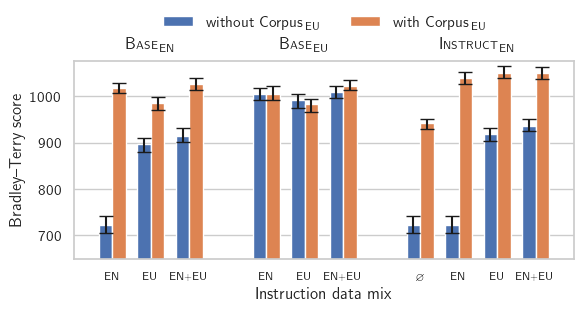

In [23]:
fig = plt.figure(figsize=(6, 3.5))

plot_ptd_elo_df = ptd_with_equiv_df.copy()
plot_ptd_elo_df = plot_ptd_elo_df.drop(index='global')

width = 0.35

# Series 1: ELOs without Basque pretraining data
bars1 = plt.bar(
    [x - width / 2 for x in x_ticks], plot_ptd_elo_df[('ELO', '0')],
    width=width,
    yerr=[plot_ptd_elo_df[('ELO lower', '0')], plot_ptd_elo_df[('ELO upper', '0')]],
    error_kw={'capsize': 5, 'capthick': 1},
    label='without Corpus\\textsubscript{\\,EU}'
)

# Series 2: ELOs with Basque pretraining data
bars2 = plt.bar(
    [x + width / 2 for x in x_ticks], plot_ptd_elo_df[('ELO', '1')],
    width=width,
    yerr=[plot_ptd_elo_df[('ELO lower', '1')], plot_ptd_elo_df[('ELO upper', '1')]],
    error_kw={'capsize': 5, 'capthick': 1},
    label='with Corpus\\textsubscript{\\,EU}'
)

# Function to modify error bar caps
def style_error_caps(container, cap_color):
    # Get the error bar lines from the bar container
    errorbar = container.errorbar
    # The caps are the 3rd and 4th elements of the errorbar container
    for cap in errorbar[1][2:4]:  # [1] gets the errorbar lines, [2:4] gets the caps
        cap.set_color(cap_color)
        cap.set_markeredgewidth(1.5)

# Apply styling
style_error_caps(bars1, 'darkblue')
style_error_caps(bars2, 'darkred')

# Group separation and titles
for group, props in plot_groups.items():
    middle = (props['start'] + props['end']) / 2
    plt.text(middle, plt.ylim()[1] * 0.98, group, ha='center', va='bottom')

plt.grid(axis='x', visible=False)
plt.xlim(-1, max(x_ticks) + 1)
plt.ylim(650, 1075)
plt.xticks(x_ticks, x_labels, fontsize=8)
plt.ylabel('Bradley--Terry score')
plt.xlabel('Instruction data mix')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncols=2, frameon=False)

plt.tight_layout()
plt.savefig('figures/q1-pretraining_data-ELO-bars.pdf', dpi=300)
plt.show()

**Conclusion: using Basque pretraining corpus is beneficial**

We continue the analysis under this assumption (i.e., discarding models that do *not* use Basque pretraining corpora during SFT).


In [24]:
result_with_equiv_ptd_df = result_with_equiv_df.filter(regex=r'\d_1\d\d', axis=0)

## 2) Impact of instruction data in the SFT data mix: Basque, English, or both?


In [25]:
inst_df = grouped_results(result_with_equiv_ptd_df, by=[BASQUE_INSTRUCTION_CORPUS, ENGLISH_INSTRUCTION_CORPUS])

display(inst_df)

90% CI                                 ELO                    \
             00       01       10       11 *(01,00) *(10,00) *(10,01)   
0_1XX       NaN  +12/-11  +12/-16  +13/-11     True     True     True   
1_1XX       NaN  +17/-14  +12/-17   +13/-8     True     True    False   
2_1XX    +9/-12  +13/-13  +14/-11  +13/-14     True     True    False   
global  +14/-18  +10/-11   +12/-9  +13/-10     True     True     True   

                                                         ELO lower          \
       *(11,00) *(11,01) *(11,10)   00    01    10    11        00  01  10   
0_1XX      True    False     True  NaN  1017   985  1025       NaN  11  16   
1_1XX      True    False     True  NaN  1005   982  1022       NaN  14  17   
2_1XX      True    False    False  942  1038  1050  1050        12  13  11   
global     True    False     True  932  1028  1005  1033        18  11   9   

           ELO upper                    acc                                   \
        11        00  01  10  11         00         01         10         11   
0_1XX   11       NaN  12  12  13        NaN  60.888859  58.973479   61.24043   
1_1XX    8       NaN  17  12  13        NaN  59.373206  59.541892  60.719462   
2_1XX   14         9  13  14  13  62.728813  64.190246   63.71842  64.199817   
global  10        14  10  12  13      62.73      61.48      60.74      62.05   

                                                                    
        Δ(01,00)  Δ(10,00)  Δ(10,01)  Δ(11,00)  Δ(11,01)  Δ(11,10)  
0_1XX        NaN       NaN  -1.91538       NaN  0.351571  2.266951  
1_1XX        NaN       NaN  0.168686       NaN  1.346256   1.17757  
2_1XX   1.461433  0.989607 -0.471826  1.471004  0.009571  0.481397  
global     -1.25     -1.99     -0.74     -0.68      0.57      1.31

## 3) Trade-off with other languages

In [26]:
from collections import Counter

benchmark_langs_df = pd.concat([benchmarks_eu_with_equiv_df.T, benchmarks_en_with_equiv_df.T, benchmarks_es_with_equiv_df.T], keys=['EU', 'EN', 'ES'], names=['lang'], axis=1)
benchmark_langs_df = benchmark_langs_df[benchmark_langs_df.index.str.match(r'\d_\d\d\d')]

benchmark_langs_df = benchmark_langs_df.T

benchmark_langs_df = benchmark_langs_df.reset_index()
benchmark_langs_df['task'] = benchmark_langs_df['task'].apply(lambda x: re.sub(r'basq|_(eus|eu|spa|es|eng|en)', '', x))
benchmark_langs_df = benchmark_langs_df.set_index(['task', 'lang'])

common_tasks = [task for task, freq in Counter([task for task, _ in benchmark_langs_df.index]).most_common() if freq > 2]

benchmark_langs_df = benchmark_langs_df[benchmark_langs_df.index.get_level_values('task').isin(common_tasks)]

In [27]:
df_prep = benchmark_langs_df.reset_index()
df_long = df_prep.melt(id_vars=['task', 'lang'], var_name='model', value_name='score')
df_long['family'] = df_long['model'].str.split('_').str[0]
df_long['config'] = df_long['model'].str.split('_').str[1]
backbones = df_long[df_long['config'] == '000'].set_index(['task', 'lang', 'family'])['score']
df_long['improvement'] = df_long.apply(lambda row: row['score'] - backbones.loc[(row['task'], row['lang'], row['family'])], axis=1) * 100
plot_data = df_long[~df_long['config'].isin(['000'])]

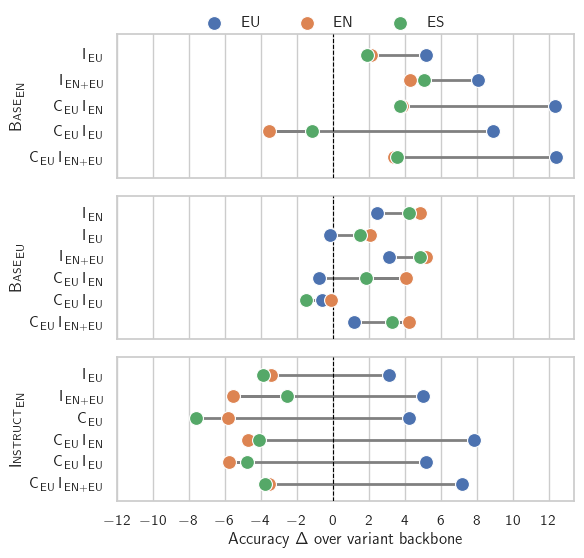

In [28]:
dumbbell_data = plot_data.copy()
dumbbell_data = dumbbell_data[dumbbell_data['model'] != '0_001']
dumbbell_data = dumbbell_data[dumbbell_data['model'] != '0_100']
dumbbell_data = dumbbell_data[dumbbell_data['model'] != '1_100']
dumbbell_data = dumbbell_data[dumbbell_data['model'] != '2_001']
dumbbell_data = dumbbell_data.groupby(['model', 'family', 'config', 'lang'])['improvement'].mean().reset_index()
dumbbell_wide = dumbbell_data.pivot(index=['model', 'family', 'config'], columns='lang', values='improvement').reset_index()

fig, axes = plt.subplots(3, 1, figsize=(6, 5.5), sharex=True)
mark_colors = sns.color_palette(n_colors=3)
languages = ['EU', 'EN', 'ES']

for ax, (family, family_data) in zip(axes, dumbbell_wide.groupby('family')):


    for idx, row in family_data.iterrows():
        improvements = [row[lang] for lang in languages]
        ax.plot(improvements, [row['model']] * 3, color='gray', linewidth=2, zorder=2)
    for i, lang in enumerate(languages):
        sns.scatterplot(data=family_data, x=lang, y='model', color=mark_colors[i], s=100, label=lang, zorder=4, ax=ax, legend=False)

    ax.axvline(0, color='black', linestyle='--', linewidth=0.8, zorder=3)

    ytick_labels = [
        pretty_model_name(f"{row['family']}_{row['config']}")
            .replace('BAS\\textsubscript{\\,EN}\\,', '')
            .replace('BAS\\textsubscript{\\,EU}\\,', '')
            .replace('INS\\textsubscript{\\,EN}\\,', '')
        for _, row in family_data.iterrows()
    ]
    y_positions = range(len(family_data))
    ax.set_yticks(ticks=y_positions, labels=ytick_labels)
    ax.set_ylim(y_positions[0] - 0.8, y_positions[-1] + 0.8)
    ax.invert_yaxis()

    ax.set_ylabel(EXP_2_BASE_MODEL[int(family)])

    ax.grid(axis='y', visible=False)
    ax.set_xticks(np.arange(-12, 14, 2))

axes[-1].set_xlabel("Accuracy $\\Delta$ over variant backbone", ha='center')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, 1.025), ncols=3, frameon=False)

plt.tight_layout()
plt.savefig('figures/language-tradeoffs.dumbbell.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 4) Correlation between arena and benchmarks

In [29]:
global_arena_rank_df = pretty_elo_df[['rank']]
pretty_lang_elo_df = pretty_lang_elo_df[['rank']]
qual_arena_rank_df = pretty_cont_elo_df[['rank']]

In [30]:
arena_rank_df = pd.concat([qual_arena_rank_df, pretty_lang_elo_df, global_arena_rank_df], axis=1)
arena_rank_df.columns = ['Content', 'Language', 'Global']
arena_rank_df = arena_rank_df.T

In [31]:
benchmarks_eu_with_equiv_df = process_benchmark_results(benchmark_with_equiv_df, tasks_filter=BASQUE_TASKS)
pretty_eu_df = benchmarks_to_pretty_table(benchmarks_eu_with_equiv_df)

benchmarks_en_with_equiv_df = process_benchmark_results(benchmark_with_equiv_df, tasks_filter=ENGLISH_TASKS)
pretty_en_df = benchmarks_to_pretty_table(benchmarks_en_with_equiv_df)

benchmarks_es_with_equiv_df = process_benchmark_results(benchmark_with_equiv_df, tasks_filter=SPANISH_TASKS,)
pretty_es_df = benchmarks_to_pretty_table(benchmarks_es_with_equiv_df)

benchmark_df = pd.concat([pretty_eu_df, pretty_en_df, pretty_es_df], keys=['EU', 'EN', 'ES'], names=['lang'], axis=1).T

common_models = list(set(benchmark_df.columns) & set(arena_rank_df.columns))
common_models = [m for m in common_models if not any(x in m for x in ('GPT', 'Claude', '70'))]  # computing only for 8B variants

benchmark_ranks_df = benchmark_df[common_models].T
arena_rank_df = arena_rank_df[common_models].T

In [32]:
language_ranks_df = benchmark_ranks_df.T.groupby('lang').mean().T.rank(method='max', ascending=False)

average_corr_df = pd.DataFrame(index=language_ranks_df.columns, columns=pd.MultiIndex.from_tuples([(l0, l1) for l0 in arena_rank_df.columns for l1 in ('rho', 'p')]))

for lang in language_ranks_df.columns:
    for arena in arena_rank_df.columns:
        corr, p = spearmanr(language_ranks_df[lang], arena_rank_df[arena])
        average_corr_df.loc[lang, (arena, 'rho')] = corr
        average_corr_df.loc[lang, (arena, 'p')] = p

display(average_corr_df)

average_corr_df.to_latex('figures/arena-benchmarks-correlation.tex', sparsify=False, float_format='{:.2f}'.format)

Content            Language              Global          
           rho         p       rho         p       rho         p
lang                                                            
EN    0.246646  0.323809  0.226006  0.367178  0.266529  0.285026
ES   -0.015488  0.951363 -0.091895  0.716862 -0.035142  0.889898
EU    0.841073  0.000012  0.805986  0.000054  0.849174  0.000008

In [33]:
benchmark_ranks_df = benchmark_ranks_df.drop(columns=[col for col in benchmark_ranks_df.columns if 'mean' in col or 'rank' in col])
benchmark_ranks_df = benchmark_ranks_df.rank(method='max', ascending=False)
benchmark_ranks_df = benchmark_ranks_df.T
benchmark_ranks_df = benchmark_ranks_df.reset_index()
benchmark_ranks_df['task'] = benchmark_ranks_df['task'].apply(lambda x: re.sub(r'basq|_(eus|eu|spa|es|eng|en)', '', x))
benchmark_ranks_df = benchmark_ranks_df.set_index(['lang', 'task']).T

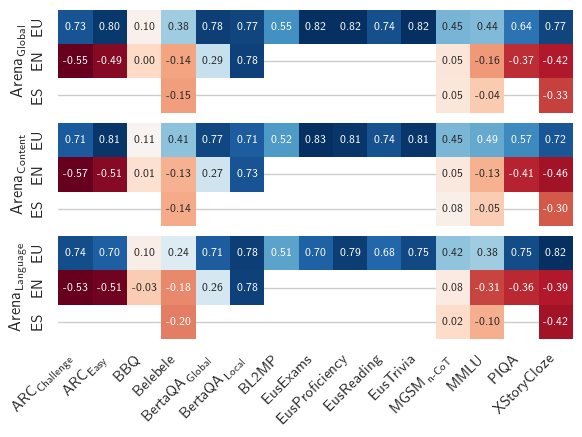

In [34]:
fig, axes = plt.subplots(3, 1, figsize=(6, 4.5), sharex=True)

pretty_tasks = ['ARC\\textsubscript{\\,Challenge}', 'ARC\\textsubscript{\\,Easy}', 'BBQ', 'Belebele', 'BertaQA\\textsubscript{\\,Global}', 'BertaQA\\textsubscript{\\,Local}', 'BL2MP', 'EusExams', 'EusProficiency', 'EusReading', 'EusTrivia', 'MGSM\\textsubscript{\\,n-CoT}', 'MMLU', 'PIQA', 'XStoryCloze']

global_corr_df = benchmark_ranks_df.apply(lambda x: spearmanr(x, arena_rank_df[['Global']]), axis=0).T
global_corr_df.columns = ['rho', 'p-value']

content_corr_df = benchmark_ranks_df.apply(lambda x: spearmanr(x, arena_rank_df[['Content']]), axis=0).T
content_corr_df.columns = ['rho', 'p-value']

language_corr_df = benchmark_ranks_df.apply(lambda x: spearmanr(x, arena_rank_df[['Language']]), axis=0).T
language_corr_df.columns = ['rho', 'p-value']

corr_dfs = [global_corr_df, content_corr_df, language_corr_df]
titles = ['Arena\\textsubscript{\\,Global}', 'Arena\\textsubscript{\\,Content}', 'Arena\\textsubscript{\\,Language}']

for i, ax in enumerate(axes):

    corr_df = corr_dfs[i]
    title = titles[i]

    lang_index = corr_df.index.get_level_values('lang')
    plot_eu_df = corr_df.iloc[lang_index == 'EU'].reset_index(level=0, drop=True)
    plot_en_df = corr_df.iloc[lang_index == 'EN'].reset_index(level=0, drop=True)
    plot_es_df = corr_df.iloc[lang_index == 'ES'].reset_index(level=0, drop=True)

    plot_corr_df = pd.concat([plot_eu_df, plot_en_df, plot_es_df], axis=1, keys=['EU', 'EN', 'ES'], join='outer')
    plot_corr_df = plot_corr_df[[('EU', 'rho'), ('EN', 'rho'), ('ES', 'rho')]]
    plot_corr_df.columns = ['EU', 'EN', 'ES']
    plot_corr_df = plot_corr_df.T

    sns.heatmap(plot_corr_df, annot=True, cmap='RdBu', fmt='.2f', annot_kws={'size': 8}, square=True, cbar=False, ax=ax)

    ax.set_ylabel(titles[i])
    ax.set_xlabel(None)

    if i == len(corr_dfs) - 1:
        ax.set_xticks([x + 0.5 for x in range(len(pretty_tasks))])
        ax.set_xticklabels(pretty_tasks, rotation=45, ha='right')
    else:
        ax.set_xticks([])
        ax.set_xlabel(None)

    ax.grid(axis='x', visible=False)

plt.tight_layout()
plt.savefig('figures/arena-benchmarks-correlation.detailed.pdf', dpi=300)
plt.show()